# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [37]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 9

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [38]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

Training accuracy is : 93.00%, Val accuracy is : 92.11%, training loss is : 0.2657, val loss is : 0.2824


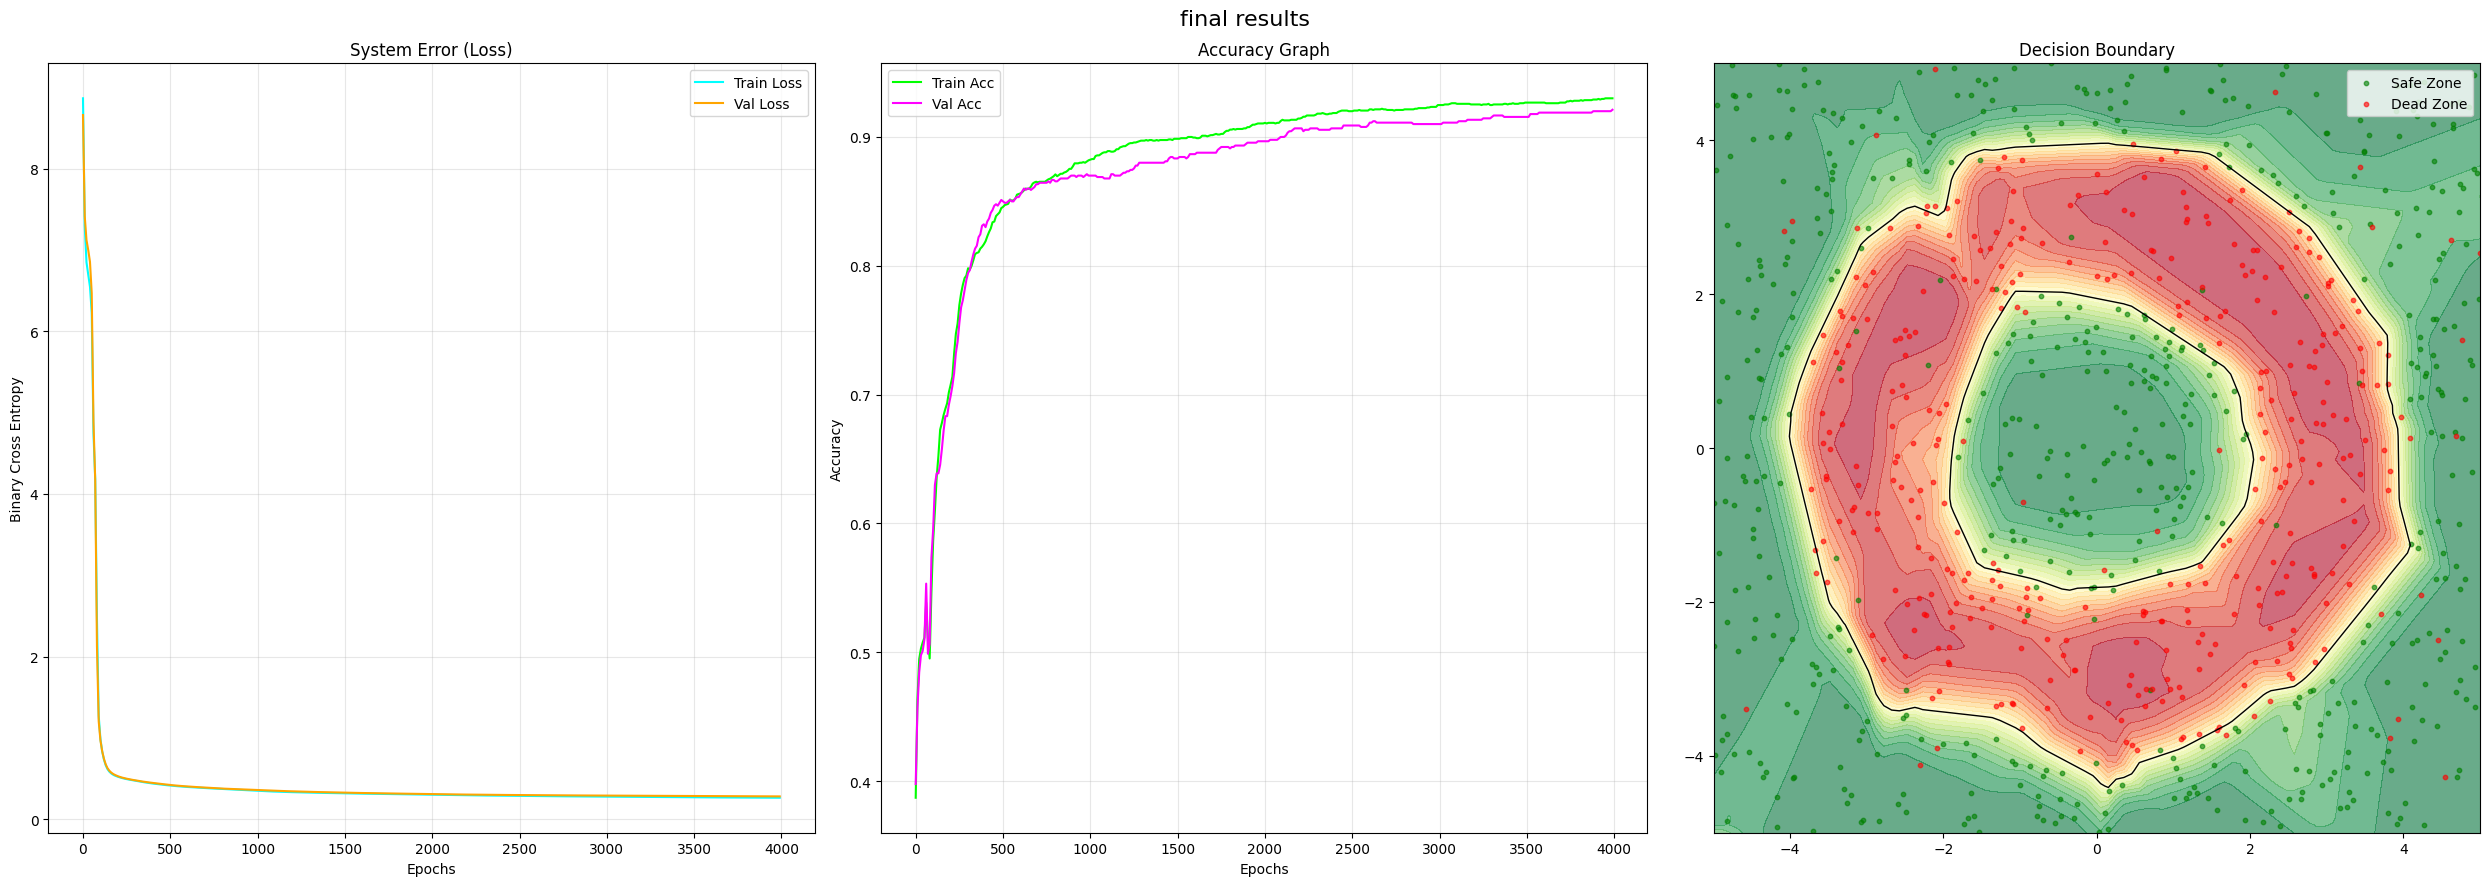

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#data generation
GROUP_NUMBER = 9

torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    X = (torch.rand(n_samples, 2) * 10) - 5
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices]
    return X.numpy(), y.numpy()

X_full, y_full = generate_data(3000)

#preprocessing

x_train_raw, x_val_raw, y_train_np, y_val_np = train_test_split(
    X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_raw)
x_val_scaled = scaler.transform(x_val_raw)

x_train = torch.tensor(x_train_scaled,dtype=torch.float32)
x_val = torch.tensor(x_val_scaled,dtype=torch.float32)
y_train = torch.tensor(y_train_np,dtype=torch.float32)
y_val = torch.tensor(y_val_np,dtype=torch.float32)

#initialization
h_size = 16
w1 = torch.randn(2, h_size, requires_grad=True)
b1 = torch.randn(h_size, requires_grad=True)
w2 = torch.randn(h_size, h_size, requires_grad=True)
b2 = torch.randn(h_size, requires_grad=True)
w3 = torch.randn(h_size, h_size, requires_grad=True)
b3 = torch.randn(h_size, requires_grad=True)
w4 = torch.randn(h_size, 1, requires_grad=True)
b4 = torch.randn(1, requires_grad=True)

params = [w1, b1, w2, b2, w3, b3, w4, b4]

#forming the function
def binary_cross_entropy(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    loss = -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return torch.mean(loss)

def forward_pass(x):
    z1 = torch.matmul(x, w1) + b1
    a1 = torch.relu(z1)
    z2 = torch.matmul(a1, w2) + b2
    a2 = torch.relu(z2)
    z3 = torch.matmul(a2, w3) + b3
    a3 = torch.relu(z3)
    z4 = torch.matmul(a3, w4) + b4
    a4 = torch.sigmoid(z4)
    return a4

#training loops
learning_rate = 0.01
epochs = 4000

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):

    #forward & loss
    y_pred = forward_pass(x_train)
    loss = binary_cross_entropy(y_pred, y_train)

    #backward
    for param in params:
        if param.grad is not None:
            param.grad.zero_()

    loss.backward()

    #update
    with torch.no_grad():
        for param in params:
            param -= learning_rate * param.grad

    #validation
    if epoch%10 == 0:
        with torch.no_grad():
            y_val_pred = forward_pass(x_val)
            val_loss = binary_cross_entropy(y_val_pred, y_val)

            train_acc = ((y_pred>0.5).float()==y_train).float().mean()
            val_acc = ((y_val_pred>0.5).float()==y_val).float().mean()

            history['train_loss'].append(loss.item())
            history['val_loss'].append(val_loss.item())
            history['train_acc'].append(train_acc.item())
            history['val_acc'].append(val_acc.item())

print(f"Training accuracy is : {train_acc.item()*100:.2f}%, Val accuracy is : {val_acc.item()*100:.2f}%, training loss is : {loss.item():.4f}, val loss is : {val_loss.item():.4f}")

fig, axs = plt.subplots(1, 3, figsize=(25,9))
plt.suptitle(f'final results', fontsize=16)

#defining the x-axis coordi's
epoch_list = list(range(0, epochs, 10))
custom_ticks = np.arange(0, epochs + 1, 500)

#plot-1-loss
axs[0].plot(epoch_list, history['train_loss'], label='Train Loss', color='cyan')
axs[0].plot(epoch_list, history['val_loss'], label='Val Loss', color='orange')
axs[0].set_title("System Error (Loss)")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Binary Cross Entropy")
axs[0].set_xticks(custom_ticks)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

#plot-2-accuracy
axs[1].plot(epoch_list, history['train_acc'], label='Train Acc', color='lime')
axs[1].plot(epoch_list, history['val_acc'], label='Val Acc', color='magenta')
axs[1].set_title("Accuracy Graph")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_xticks(custom_ticks)
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# plot-3-decision boundary
x_min,x_max = -5,5
y_min,y_max = -5,5
xx,yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(scaler.transform(grid_points), dtype=torch.float32)

with torch.no_grad():
    grid_probs = forward_pass(grid_tensor).reshape(xx.shape)

axs[2].set_title("Decision Boundary")
axs[2].contourf(xx, yy, grid_probs, levels=20, cmap='RdYlGn_r', alpha=0.6)
axs[2].contour(xx, yy, grid_probs, levels=[0.5], colors='black', linewidths=1)

safe_mask = (y_val_np.flatten() == 0)
dead_mask = (y_val_np.flatten() == 1)
axs[2].scatter(x_val_raw[safe_mask, 0], x_val_raw[safe_mask, 1], c='green', s=10, label='Safe Zone', alpha=0.6)
axs[2].scatter(x_val_raw[dead_mask, 0], x_val_raw[dead_mask, 1], c='red', s=10, label='Dead Zone', alpha=0.6)
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()
